In [5]:
import numpy as np
import pandas as pd
import seaborn as sns
import re

from matplotlib import pyplot as plt
from matplotlib.lines import Line2D

from collections import Counter

all_markers = list(Line2D.markers.keys())

# Analyzing NOSC of the E. coli proteome
This notebook calculates the condition dependent proteome NOSC for the datasets aggregated by Chure & Bellivue et al. Cell Systems 2021. To calculate the proteome NOSC we need near-complete proteome datasets such that the uncertainty related to unmeasured proteins is small. Recent datasets of this quality were collected by Griffin Chure and Nathan Bellivue. 

Since proteome NOSC is a weighted average of contributions from individual proteins, we do not need absolute measurements with real units. Rather, we need accurate and complete compositional data, i.e. protein A makes P% of the proteome. 

# Differences between lab practices
Valgepea 2013 uses data collected in Valgepea 2010, where E. coli was cultured in a custom minimal medium documented in Nahku et al. 2010. Peebo et al. 2015 is from the same group (Vilu) and appears to use the same growth medium base with some amino acid supplementation. 

Minimal media used by Schmidt et al. 2015 uses an M9 base that is distinct from the medium in the Vilu group. 

# Known issues
I am using MG1655 coding sequences for all samples, but Schmidt et al. and Peebo et al. are working with BW25113. The BW25113 is derived from MG1655 with a small number deletions and other changes documented in the genome announcement. https://www.ncbi.nlm.nih.gov/pmc/articles/PMC4200154/

# Some additional E. coli data sources
* Hui et al. MSB 2015 is from Hwa & Williamson groups
* Maser et al. 2021 from Vilu and Nahku groups
* Mori et al. 2022 

In [6]:
raw_abund_df = pd.read_csv('../data/proteomes/Coli/Chure_compiled_absolute_measurements.csv', index_col=0).reset_index().set_index('b_number')
nosc_df = pd.read_csv('../data/genomes/Coli/MG1655/MG1655_ref_prot_NOSC.csv').set_index('b_number')

In [7]:
nosc_df.head(2)

,aa_seq,num_aas,mw_daltons,transmembrane_aas,transmembrane_Cs,fraction_transmembrane,fraction_transmembrane_C,primary_accession,accessions,gene_name,...,COG_IDs,KEGG_IDs,isoform_accessions,KEGG_path_IDs,KEGG_pathways,Ce,NC,NOSC,eC_ratio,organism
b_number,,,,,,,,,,,,,,,,,,,,,
b4586,MRLHVKLKEFLSMFFMAILFFPAFNASLFFTGVKPLYSIIKCSTEI...,159,18118.0,60.0,345.0,0.377358,0.400232,A5A605,"A5A605,P71282",ykfM,...,ENOG5031M8I,eco:b4586,NaN,NaN,NaN,-301.25,862.0,-0.349478,4.349478,coli
b1252,MTLDLPRRFPWPTLLSVCIHGAVVAGLLYTSVHQVIELPAPAQPIS...,239,26094.0,31.0,159.0,0.129707,0.135550,P02929,"P02929,P76831,P94719,P94722,P94726,P94728,P947...",tonB,...,COG0810,"ecj:JW5195,eco:b1252",NaN,NaN,NaN,-244.16,1173.0,-0.208150,4.208150,coli


In [8]:
# Take the mean of replicates for the same gene. 
# Note 1: have to do this because didn't report which measurement is from which replicate.
# Note 2: the Schmidt data is already aggregated across two measurement methods.
# NB: Assuming same dataset, strain, cond, gene and growth rate implies replicate. 
counts = raw_abund_df.reset_index().groupby('dataset,strain,condition,b_number,growth_rate_hr'.split(',')).mean()
# renaming tot_per_cell for clarity and to match how we treat other datasets
abund_df = counts.reset_index().set_index('b_number').rename(
    columns=dict(tot_per_cell='copies_per_cell'))

# Keep only the b-numbers that we have abundance and NOSC data for.
overlapping_idx = set(nosc_df.index.values).intersection(abund_df.index.values)
abund_df = abund_df.loc[overlapping_idx].copy()
nosc_df = nosc_df.loc[overlapping_idx].copy()

# Add NOSC and NC data to the abundance dataframe
abund_df['NOSC'] = nosc_df.loc[abund_df.index.values].NOSC
abund_df['NC_per'] = nosc_df.loc[abund_df.index.values].NC
abund_df['num_aas'] = nosc_df.loc[abund_df.index.values].num_aas
abund_df['mw_daltons'] = nosc_df.loc[abund_df.index.values].mw_daltons
abund_df['organism_key'] = 'coli'
abund_df['species'] = 'E. coli'
abund_df['majority_protein_ids'] = nosc_df.loc[abund_df.index.values].primary_accession
abund_df['fraction_transmembrane'] = nosc_df.loc[abund_df.index.values].fraction_transmembrane
abund_df['fraction_transmembrane_C'] = nosc_df.loc[abund_df.index.values].fraction_transmembrane

# Add annotation of the growth mode -- presumed batch
abund_df['growth_mode'] = 'batch'
# Conditions called "chemostat" are definitely chemostat conds
abund_df.loc[abund_df.condition.str.startswith('chemostat'), 'growth_mode'] = 'chemostat'
# Li et al. data is all batch culture - can leave untouched.
# Peebo et al. data is all in "accelerostats" which are chemostats
abund_df.loc[abund_df.dataset == 'peebo_2015', 'growth_mode'] = 'chemostat'
# Valgepea et al. data is also likewise 2013
abund_df.loc[abund_df.dataset == 'valgepea_2013', 'growth_mode'] = 'chemostat'

# Add annotation of stress conditions -- presumed non-stess
abund_df['stress'] = False
abund_df.loc[abund_df.condition == '42C', 'stress'] = True
abund_df.loc[abund_df.condition == 'osmotic_stress_glucose', 'stress'] = True
abund_df.loc[abund_df.condition == 'pH6', 'stress'] = True

# Formal Carbon-bound e- per protein copy
abund_df['Ce_per'] = nosc_df.loc[abund_df.index].Ce
# Total Carbon-bound e-/cell on this protein, i.e. weighted by copies/cell 
abund_df['Ce_total'] = abund_df.Ce_per * abund_df.copies_per_cell
# Total Carbon atoms on this protein, i.e. weighted by copies/cell 
abund_df['NC_total'] = abund_df.NC_per * abund_df.copies_per_cell
abund_df
abund_df.to_csv('../data/proteomes/Coli/Chure_mean_absolute_measurements.csv')
abund_df.head()

TypeError: Could not convert thrL to numeric

In [ ]:
abund_df.groupby('dataset,condition'.split(',')).first().sort_index()

strain  growth_rate_hr  \
dataset       condition                                                   
li_2014       MOPS complete                      MG1655        1.934364   
              MOPS complete without methionine   MG1655        1.569390   
              MOPS minimal                       MG1655        0.738700   
peebo_2015    glucose_minimal                   BW25113        0.210000   
              rich                              BW25113        0.250000   
schmidt_2016  42C                               BW25113        0.660000   
              acetate                           BW25113        0.300000   
              chemostat_u0.12                   BW25113        0.120000   
              chemostat_u0.2                    BW25113        0.200000   
              chemostat_u0.35                   BW25113        0.350000   
              chemostat_u0.5                    BW25113        0.500000   
              fructose                          BW25113        0.650000   
              fumarate                          BW25113        0.420000   
              galactose                         BW25113        0.260000   
              glucosamine                       BW25113        0.460000   
              glucose                           BW25113        0.580000   
              glycerol                          BW25113        0.470000   
              glycerol_pAA                      BW25113        1.270000   
              lb_miller                         BW25113        1.900000   
              mannose                           BW25113        0.470000   
              osmotic_stress_glucose            BW25113        0.550000   
              pH6                               BW25113        0.630000   
              pyruvate                          BW25113        0.400000   
              succinate                         BW25113        0.440000   
              xylose                            BW25113        0.550000   
valgepea_2013 glucose_minimal                    MG1655        0.110000   

                                                copies_per_cell  fg_per_cell  \
dataset       condition                                                        
li_2014       MOPS complete                          105.647177     0.002915   
              MOPS complete without methionine       278.825105     0.010142   
              MOPS minimal                           360.689748     0.009954   
peebo_2015    glucose_minimal                         97.673975     0.002695   
              rich                                    74.064603     0.002044   
schmidt_2016  42C                                    272.268322     0.007513   
              acetate                                147.015607     0.004057   
              chemostat_u0.12                        182.004991     0.005023   
              chemostat_u0.2                         137.023553     0.003781   
              chemostat_u0.35                        141.887995     0.003916   
              chemostat_u0.5                          94.579432     0.002610   
              fructose                               112.135042     0.003094   
              fumarate                               120.279673     0.003319   
              galactose                              268.029691     0.007397   
              glucosamine                            383.636115     0.010587   
              glucose                                103.015028     0.002843   
              glycerol                               109.910048     0.003033   
              glycerol_pAA                           145.703478     0.004021   
              lb_miller                              261.850628     0.007226   
              mannose                                139.028642     0.003837   
              osmotic_stress_glucose                 331.329686     0.009143   
              pH6                                    545.929053     0.015065   
              pyruvate      

In [ ]:
# amino acid counts per protein
aa_counts = [Counter(a) for a in nosc_df.aa_seq]
aa_counts_df = pd.DataFrame(aa_counts, index=nosc_df.index).replace({np.NaN: 0})
aa_counts_df.head()

,M,K,R,L,I,T,A,P,F,V,...,Q,N,Y,S,H,E,D,C,W,U
b_number,,,,,,,,,,,,,,,,,,,,,
b3448,8,4.0,8.0,17.0,7.0,9.0,3.0,15.0,2.0,2.0,...,29.0,18.0,1.0,7.0,2.0,3.0,3.0,0.0,0.0,0.0
b1631,2,13.0,7.0,21.0,10.0,18.0,30.0,8.0,6.0,12.0,...,12.0,5.0,5.0,7.0,6.0,9.0,12.0,2.0,2.0,0.0
b3485,24,5.0,20.0,46.0,33.0,24.0,28.0,21.0,21.0,29.0,...,13.0,17.0,6.0,25.0,4.0,13.0,12.0,0.0,4.0,0.0
b0956,4,16.0,11.0,18.0,8.0,5.0,11.0,2.0,2.0,8.0,...,10.0,8.0,4.0,7.0,5.0,16.0,5.0,0.0,4.0,0.0
b0457,13,19.0,27.0,55.0,51.0,22.0,34.0,26.0,11.0,31.0,...,29.0,15.0,19.0,39.0,20.0,34.0,27.0,3.0,13.0,0.0


In [ ]:
# get the fast growth sample from schmidt
mask = np.logical_and(abund_df.dataset == 'schmidt_2016',
                      abund_df.condition == 'chemostat_u0.5')
mean_abund_fast_growth = abund_df[mask].reset_index().set_index('b_number').replace({np.NaN: 0})

overlapping_ids = set(mean_abund_fast_growth.index).intersection(aa_counts_df.index)
tmp = aa_counts_df.loc[overlapping_ids].multiply(mean_abund_fast_growth.loc[overlapping_ids].copies_per_cell, axis=0).sum()
expression_weighted_aas = tmp / tmp.sum()
expression_weighted_aas.name = 'aa_freq'

expression_weighted_aas.to_csv('../data/proteomes/Coli/Schmidt_mu0.5_expression_weighted_aa_freqs.csv')

In [ ]:
proteome_nosc_df = abund_df.groupby('dataset,strain,condition,growth_rate_hr,growth_mode'.split(',')).sum()
proteome_nosc_df = proteome_nosc_df[['Ce_total', 'NC_total']].copy() 
proteome_nosc_df['proteome_NOSC'] = proteome_nosc_df.Ce_total / proteome_nosc_df.NC_total
proteome_nosc_df = proteome_nosc_df.reset_index()
proteome_nosc_df.to_csv('../data/proteomes/Coli/Chure_proteome_NOSC.csv', index=False)
proteome_nosc_df

,dataset,strain,condition,growth_rate_hr,growth_mode,Ce_total,NC_total,proteome_NOSC
0,li_2014,MG1655,MOPS complete,1.934364,batch,-2.873416e+09,1.979388e+10,-0.145167
1,li_2014,MG1655,MOPS complete without methionine,1.569390,batch,-2.085635e+09,1.456026e+10,-0.143242
2,li_2014,MG1655,MOPS minimal,0.738700,batch,-1.020722e+09,7.199098e+09,-0.141785
3,peebo_2015,BW25113,glucose_minimal,0.210000,chemostat,-6.324929e+08,4.438966e+09,-0.142487
4,peebo_2015,BW25113,glucose_minimal,0.220000,chemostat,-6.374814e+08,4.479156e+09,-0.142322
5,peebo_2015,BW25113,glucose_minimal,0.260000,chemostat,-6.634983e+08,4.644507e+09,-0.142857
6,peebo_2015,BW25113,glucose_minimal,0.310000,chemostat,-6.981347e+08,4.862400e+09,-0.143578
7,peebo_2015,BW25113,glucose_minimal,0.360000,chemostat,-7.349312e+08,5.084070e+09,-0.144556
8,peebo_2015,BW25113,glucose_minimal,0.410000,chemostat,-7.671303e+08,5.321234e+09,-0.144164
9,peebo_2015,BW25113,glucose_minimal,0.460000,chemostat,-8.052165e+08,5.566319e+09,-0.144659


In [ ]:
abund_df

,dataset,strain,condition,growth_rate_hr,copies_per_cell,fg_per_cell,NOSC,NC_per,num_aas,mw_daltons,organism_key,species,majority_protein_ids,fraction_transmembrane,fraction_transmembrane_C,growth_mode,stress,Ce_per,Ce_total,NC_total
b_number,,,,,,,,,,,,,,,,,,,,
b3448,li_2014,MG1655,MOPS complete,1.934364,105.647177,0.002915,-0.031204,706.0,146,16624.0,coli,E. coli,P0ADX7,0.000000,0.000000,batch,False,-22.03,-2327.407299,7.458691e+04
b3448,li_2014,MG1655,MOPS minimal,0.738700,360.689748,0.009954,-0.031204,706.0,146,16624.0,coli,E. coli,P0ADX7,0.000000,0.000000,batch,False,-22.03,-7945.995146,2.546470e+05
b3448,peebo_2015,BW25113,glucose_minimal,0.210000,97.673975,0.002695,-0.031204,706.0,146,16624.0,coli,E. coli,P0ADX7,0.000000,0.000000,chemostat,False,-22.03,-2151.757671,6.895783e+04
b3448,peebo_2015,BW25113,glucose_minimal,0.220000,NaN,NaN,-0.031204,706.0,146,16624.0,coli,E. coli,P0ADX7,0.000000,0.000000,chemostat,False,-22.03,NaN,NaN
b3448,peebo_2015,BW25113,glucose_minimal,0.260000,NaN,NaN,-0.031204,706.0,146,16624.0,coli,E. coli,P0ADX7,0.000000,0.000000,chemostat,False,-22.03,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
b0093,li_2014,MG1655,MOPS complete without methionine,1.569390,210.341746,0.010976,-0.111302,1383.0,276,31434.0,coli,E. coli,P06136,0.072464,0.072464,batch,False,-153.93,-32377.904937,2.909026e+05
b0093,li_2014,MG1655,MOPS minimal,0.738700,167.789218,0.008755,-0.111302,1383.0,276,31434.0,coli,E. coli,P06136,0.072464,0.072464,batch,False,-153.93,-25827.794350,2.320525e+05
b0355,li_2014,MG1655,MOPS complete,1.934364,1429.538357,0.074570,-0.099943,1412.0,277,31424.0,coli,E. coli,P51025,0.000000,0.000000,batch,False,-141.12,-201736.452987,2.018508e+06


('peebo_2015', 'glucose_minimal') [0.21 0.22 0.26 0.31 0.36 0.41 0.46 0.51]
('peebo_2015', 'rich') [0.25 0.35 0.42 0.45 0.53 0.55 0.63 0.65 0.73 0.74 0.78 0.82]
('valgepea_2013', 'glucose_minimal') [0.11 0.21 0.31 0.4  0.49]


Text(0.5, 0, 'growth rate')

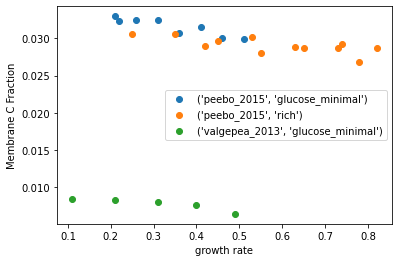

In [ ]:
for idx, gdf in abund_df.groupby('dataset,condition'.split(',')):
    grs = gdf.growth_rate_hr.unique()
    if grs.size < 3:
        continue 
    print(idx, grs)
    
    # Calculate the number of C atoms in the membrane
    tmp = gdf.NC_total * gdf.fraction_transmembrane_C
    transmemC = tmp.groupby(gdf.growth_rate_hr).sum()
    
    # Normalize by total C amount
    norm_factor = gdf.groupby('growth_rate_hr').sum()
    transmemC_norm = transmemC / norm_factor.NC_total
    
    plt.scatter(transmemC_norm.index, transmemC_norm, label=idx)
    
plt.legend()
plt.ylabel('Membrane C Fraction')
plt.xlabel('growth rate')